# Predicting Presence of Heart Disease

Christopher Simms 59032219

Juhi Grover 76008424

Etan Huang 29998721

Wendy Wang 38122164




**TODO LIST:**

- discuss why our classifier was not accurate and how it could be improved - Etan
- general look-through/grammar editing


link to other project: https://github.com/omertahi/DSCI100-Group26-Project/blob/main/forest_fire_report.ipynb

## Introduction

Heart disease refers to various conditions that affect the heart, including blood vessel disease, irregular heartbeats, heart valve disease, etc.

"Heart disease is responsible for most deaths worldwide for both men and women of all races, accounting for about 1 in every 4 deaths." (Thomas 2020 - Healthline.com), making it one of the major causes of death. Heart disease is sometimes referred to as “silent” because, in many cases, it is not diagnosed until the individual experiences signs or symptoms of a heart attack or heart failure. Being such a major cause of death, usually through heart attacks, it would be very helpful if we could identify those with the condition before too many symptoms have a chance to manifest.

Since it is difficult to diagnose heart disease before more severe symptoms start to appear, our goal is to predict heart disease diagnosis based on known risk factors like high blood pressure and high cholesterol, so that heart disease can be caught even before symptoms start to appear. By detecting heart disease before symptoms begin to appear, patients can receive the right treatment ahead of time and have a greater chance of survival. Looking online, there are many identified risk factors, which include obesity, diabetes and high blood pressure, among other conditions and lifestyle habits. How can we be sure which of these risk factors significantly increase chances of heart disease, and by how much do they increase the risk?

Our analysis will be guided by the following question: **Can we accurately predict the presence of heart disease based on several key predictors?**



The dataset we are using is a Heart Disease Data Set (Janosi et al.) that contains information about a person's age, sex, other medical factors and whether the individual was diagnosed with heart disease. The dataset contains 13 variables for which observations were collected, with a mixture of categorical and numerical variables. The data set also contains a diagnosis column which will be the categorical class we are predicting, with 0 being a negative diagnosis and 1 a positive diagnosis for heart disease.

## Method

Out of the 13 variables in our dataset, five were numerical. We chose to use four of these five: age, max heart rate, resting blood pressure and cholesterol levels. The fifth, which looks at ST wave depressions caused by exercise, was omitted because it is too complex for our needs, and correctly interpreting its meaning requires significant understanding of the biology of the heart.

In order to predict the presence of heart disease, we will use a K-Nearest Neighbours classification model, trained on the four predictor variables mentioned above. Below is an overview of classsification methodology:

**- Reading and Wrangling:** Reading our dataset and cleaning the data into a tidy format

**- Splitting the dataset:** Splitting the dataset into testing and training sets

**- K Nearest Neighbours Classification:** Tuning the model with cross validation, retraining our model based on the best K value, fitting the model to our testing data and calculating the accuracy estimate

**- Results and Conclusion:** Intepreting our results and looking at ways it could be improved. 

In [82]:
#run this cell before continuing
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(repr)
options(repr.matrix.max.rows = 6)

### Data Tidying ###

We begin by importing our dataset and assigning names to the columns, which are given on the dataset's website but not included in the file. We also set many of the predictor variables to factors, since they are incorrectly imported as numeric. Also removed any NA values that my be present in the data set.

In [83]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_import <- read_csv(url, 
                               col_names=c("age",
                                           "sex",
                                           "chest_pain_type",
                                           "resting_blood_pressure",
                                           "cholesterol_level",
                                           "high_fasting_blood_sugar",
                                           "resting_ecg_results",
                                           "max_heart_rate",
                                           "exercise_induced_angina",
                                           "ST_depression_induced_by_exercise",
                                           "slope_of_peak_exercise_ST_segment",
                                           "num_blood_vessels_colored",
                                           "thal",
                                           "diagnosis_old"))

mutated_heart_disease <- heart_disease_import |>
                        mutate(sex = as_factor(sex)) |>
                        mutate(chest_pain_type = as_factor(chest_pain_type)) |>
                        mutate(high_fasting_blood_sugar = as_factor(high_fasting_blood_sugar)) |>
                        mutate(resting_ecg_results = as_factor(resting_ecg_results)) |>
                        mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
                        mutate(slope_of_peak_exercise_ST_segment = as_factor(slope_of_peak_exercise_ST_segment)) |>
                        mutate(num_blood_vessels_colored = as_factor(num_blood_vessels_colored)) |>
                        mutate(thal = as_factor(thal)) |>
                        na.omit()

mutated_heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): num_blood_vessels_colored, thal
dbl (12): age, sex, chest_pain_type, resting_blood_pressure, cholesterol_lev...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain_type,resting_blood_pressure,cholesterol_level,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise,slope_of_peak_exercise_ST_segment,num_blood_vessels_colored,thal,diagnosis_old
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### Adding a New Diagnosis Column

Before continuing, we need to add a new diagnosis column, which we will do below. This is because the dataset's diagnosis column includes values from 0 to 4, but the website comments that all analyses done on the dataset only tried to detect the presence of heart disease, not the severity (which is indicated by the values between 1 and 4). Because of this, we will mutate a new column named "diagnosis" that has a 1 for every nonzero value in the old diagnosis column.

In [84]:
heart_disease_data <- mutated_heart_disease |>
                mutate(diagnosis= ifelse(diagnosis_old>0,1,0)) |>
                mutate(diagnosis_old = as_factor(diagnosis_old)) |>
                mutate(diagnosis = as_factor(diagnosis))
heart_disease_data

age,sex,chest_pain_type,resting_blood_pressure,cholesterol_level,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise,slope_of_peak_exercise_ST_segment,num_blood_vessels_colored,thal,diagnosis_old,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0,0


### Exploratory Data Analysis

In [85]:
stats_max <- c(max(heart_disease_data$age), max(heart_disease_data$max_heart_rate), max(heart_disease_data$resting_blood_pressure), max(heart_disease_data$cholesterol_level))
stats_min <- c(min(heart_disease_data$age), min(heart_disease_data$max_heart_rate), min(heart_disease_data$resting_blood_pressure), min(heart_disease_data$cholesterol_level))
stats_mean <- c(mean(heart_disease_data$age), mean(heart_disease_data$max_heart_rate), mean(heart_disease_data$resting_blood_pressure), mean(heart_disease_data$cholesterol_level))
stats_sd <- c(sd(heart_disease_data$age), sd(heart_disease_data$max_heart_rate), sd(heart_disease_data$resting_blood_pressure), sd(heart_disease_data$cholesterol_level))
stats_rows <- c(length(heart_disease_data$age), length(heart_disease_data$max_heart_rate), length(heart_disease_data$resting_blood_pressure), length(heart_disease_data$cholesterol_level))

stats <- matrix(c(stats_max, stats_min, stats_mean, stats_sd, stats_rows), ncol=5, byrow=FALSE)
colnames(stats) <- c('Max', 'Min', 'Mean', 'Standard Deviation', '# of Data Points')
rownames(stats) <- c('Age', 'Max Heart Rate (BPM)', 'Resting Blood Pressure (mmHg)', 'Cholesterol Level (mg/dl)')

summary_stats <- as.table(stats)
summary_stats

                                     Max        Min       Mean
Age                            77.000000  29.000000  54.438944
Max Heart Rate (BPM)          202.000000  71.000000 149.607261
Resting Blood Pressure (mmHg) 200.000000  94.000000 131.689769
Cholesterol Level (mg/dl)     564.000000 126.000000 246.693069
                              Standard Deviation # of Data Points
Age                                     9.038662       303.000000
Max Heart Rate (BPM)                   22.875003       303.000000
Resting Blood Pressure (mmHg)          17.599748       303.000000
Cholesterol Level (mg/dl)              51.776918       303.000000

**Table 1: Summary Statistics of Predictor Variables**

Table 1 contains the summary statistics(max, min, mean, standard deviation, number of data points) of the variables used in our analysis.

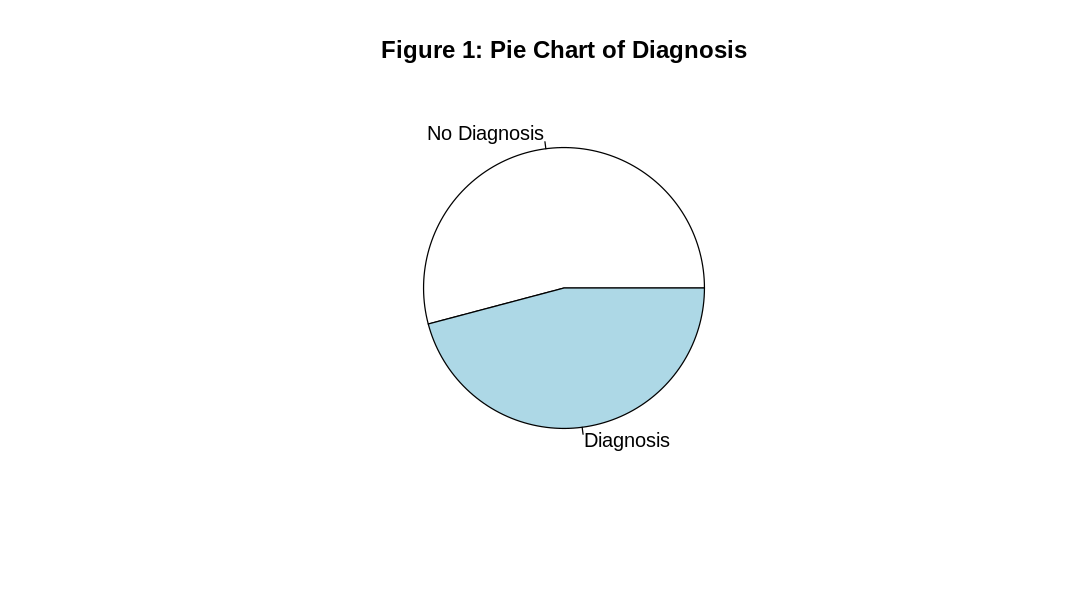

In [86]:
diagnosis_count <- heart_disease_data |>
    group_by(diagnosis) |>
    summarize(count = n()) |>
    pull(count)
diagnosis_pie <- pie(diagnosis_count, labels = c("No Diagnosis", "Diagnosis"), main = "Figure 1: Pie Chart of Diagnosis")

This pie chart above shows the proportion of people that are diagnosed and not diagnosed. A little less than half of our sample is diagnosed with heart disease of various severity. 

### Distribution of Predictor Variables (All Data)

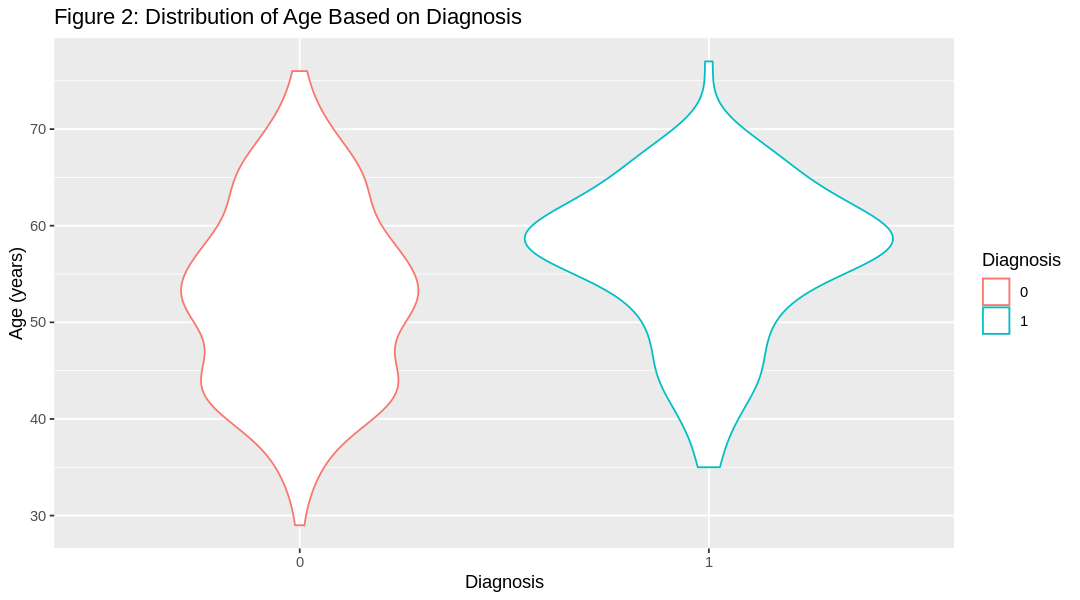

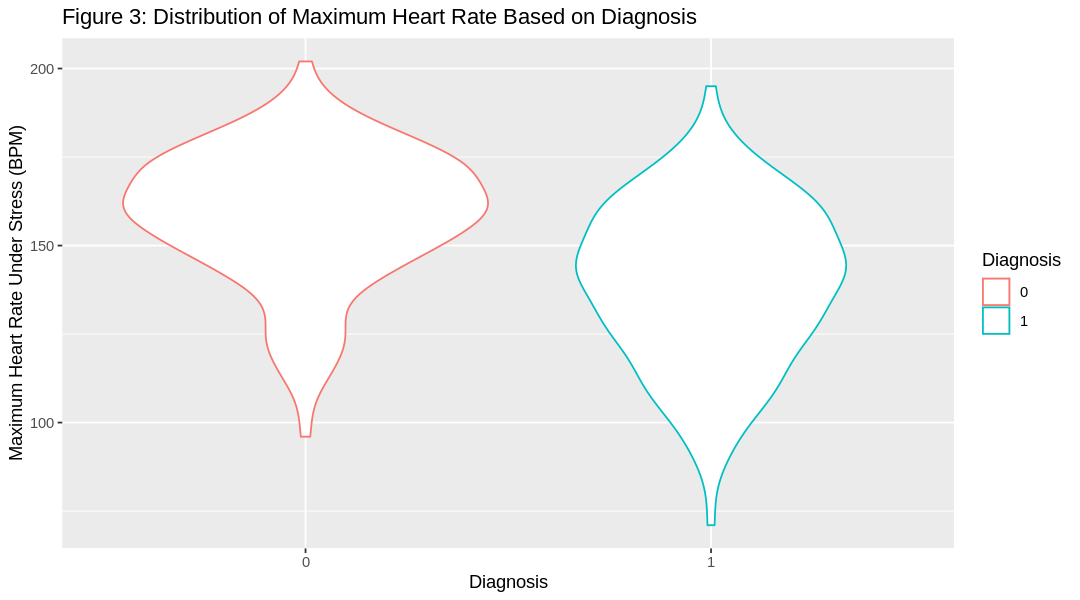

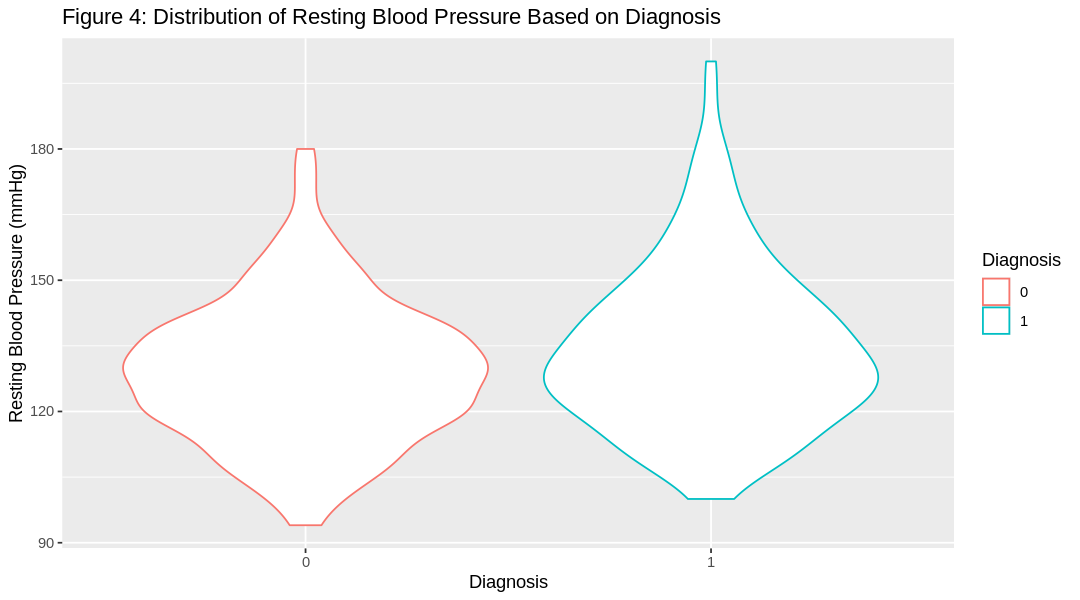

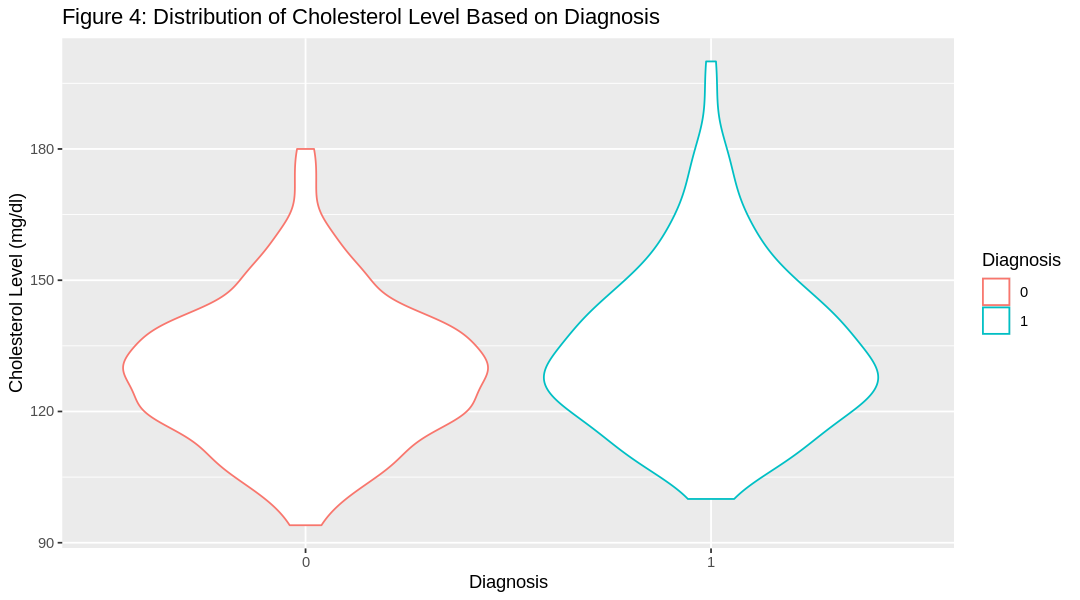

In [87]:
age_dis <- ggplot(heart_disease_data, aes(x=diagnosis, y=age, color=diagnosis)) +
    geom_violin() +
    ggtitle('Figure 2: Distribution of Age Based on Diagnosis') +
    labs(x='Diagnosis', y='Age (years)', color='Diagnosis')
hr_dis <- ggplot(heart_disease_data, aes(x=diagnosis, y=max_heart_rate, color=diagnosis)) +
    geom_violin() +
    ggtitle('Figure 3: Distribution of Maximum Heart Rate Based on Diagnosis') +
    labs(x='Diagnosis', y='Maximum Heart Rate Under Stress (BPM)', color='Diagnosis')
bp_dis <- ggplot(heart_disease_data, aes(x=diagnosis, y=resting_blood_pressure, color=diagnosis)) +
    geom_violin() +
    ggtitle('Figure 4: Distribution of Resting Blood Pressure Based on Diagnosis') +
    labs(x='Diagnosis', y='Resting Blood Pressure (mmHg)', color='Diagnosis')
chol_dis <- ggplot(heart_disease_data, aes(x=diagnosis, y=resting_blood_pressure, color=diagnosis)) +
    geom_violin() +
    ggtitle('Figure 4: Distribution of Cholesterol Level Based on Diagnosis') +
    labs(x='Diagnosis', y='Cholesterol Level (mg/dl)', color='Diagnosis')

age_dis
hr_dis
bp_dis
chol_dis

Figures 2 to 4 show the distribution of all the predictor variables separated by the status of diagnosis. Figure 2 shows that there are more olderindividuals with heart disease and figure 3 shows that individuals with heart disease have a lower maximum heart rate when put under stress. Figures 4 and 5 do not show much of the difference between individual with or without heart disease.

### Splitting the Data

We now split the data into training and testing sets, using a proportion of 0.75 so that our training set will contain 75% of the data points and our testing set will contain 25%. We will also be using set.seed() to ensure that our results are reproducible.

In [88]:
set.seed(1000)

heart_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

### Distribution of Predictor Variables (Training Data)

Before undertaking the analysis, let us visualize the distributions of our predictor variables in order to see if there are any trends or patterns that pop out. These trends may help us to better predict/understand the outcome of our classifier.

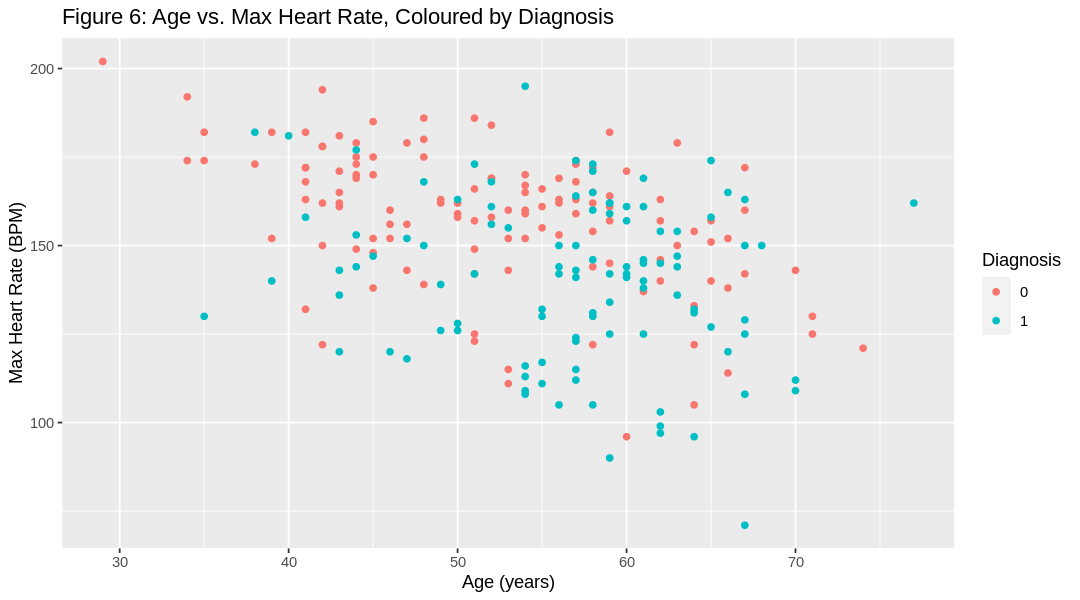

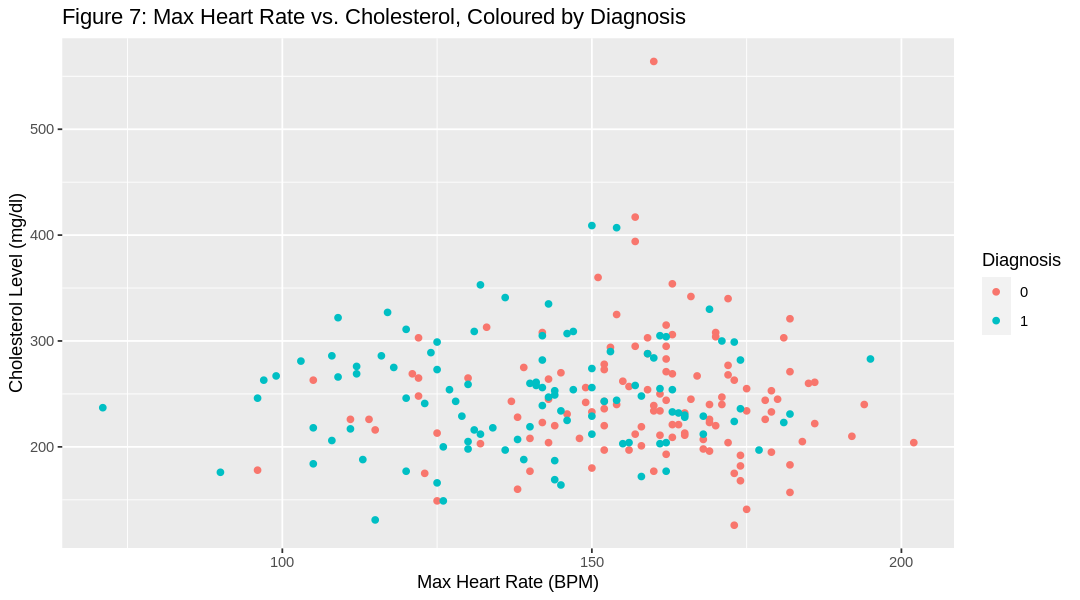

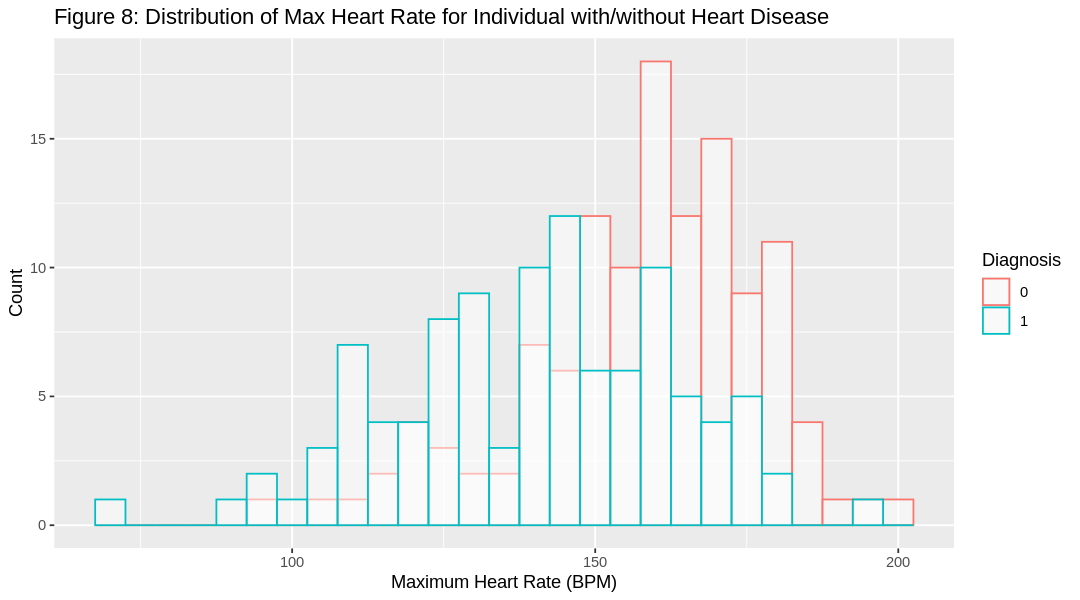

In [89]:
options(repr.plot.width=9,repr.plot.height=5)

heart_plot <- heart_training |>
            ggplot(aes(x=age,y=max_heart_rate,color=diagnosis)) +
            geom_point() +
            ggtitle("Figure 6: Age vs. Max Heart Rate, Coloured by Diagnosis") +
            labs(x="Age (years)",
                 y="Max Heart Rate (BPM)",
                 color="Diagnosis")

cholesterol_plot <- heart_training |>
            ggplot(aes(x=max_heart_rate,y=cholesterol_level,color=diagnosis)) +
            geom_point() +
            ggtitle("Figure 7: Max Heart Rate vs. Cholesterol, Coloured by Diagnosis") +
            labs(x="Max Heart Rate (BPM)",
                 y="Cholesterol Level (mg/dl)",
                 color="Diagnosis")

hr_distribution_plot <- ggplot(heart_training, aes(x=max_heart_rate, color = diagnosis)) +
    geom_histogram(fill="white", alpha=0.5, position="identity", binwidth=5) +
    labs(x= "Maximum Heart Rate (BPM)",y="Count", color = "Diagnosis") +
    ggtitle("Figure 8: Distribution of Max Heart Rate for Individual with/without Heart Disease")


heart_plot
cholesterol_plot
hr_distribution_plot

While no immediately obvious divides appear here, the figure 6 seems to hint that heart disease may be positively correlated with age, and negatively with max heart rate under stress. Figure 7 reinforces the role of max heart rate, as does Figure 8.

### Creating the Recipe and Model

We create a recipe to predict the diagnosis based on four different quantitative variables- age, maximum heart rate, cholesterol level and resting blood pressure. We standardize our data and set the mean of the variables equal to 0, & the standard deviation equal to 1. 
We will also create a k-nearest neighbors classification model using our training data, where we will tune our number of neighbors to find the best value of K. 

In [90]:
heart_recipe <- recipe(diagnosis ~ age + max_heart_rate + cholesterol_level + resting_blood_pressure, data = heart_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")


heart_recipe
knn_spec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Performing Cross-Validation

We will now perform cross validation. Cross validation involves comparing the acuracy of the classifier (that was trained on the training data) for different values of K. Here, we perform a 5-fold cross validation to determine the best value of K. We create a workflow with our recipe and model, and find the accuracy for different values of K. We finally determine the value of K with the largest accuracy. 

In [91]:
set.seed(123)

heart_vfold <- vfold_cv(heart_training, v = 5, strata = diagnosis)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 2)) 

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = gridvals) |>
  collect_metrics()

### Visualizing Cross-Validation Results

To choose the best value of K, we will now visulaize our results using a line and scatterplot. The best value of K will be the value with a relatively high accuarcy and where changing the k value to a nearby value will not decrease the accuracy much. We will also try to choose a K value that is not computationally expensibve,i.e, doesn't take very long to process.  

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
37,accuracy,binary,0.7009135,5,0.02498389,Preprocessor1_Model19
29,accuracy,binary,0.6922222,5,0.02412515,Preprocessor1_Model15
33,accuracy,binary,0.6876768,5,0.01941270,Preprocessor1_Model17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,accuracy,binary,0.6301757,5,0.012749967,Preprocessor1_Model03
1,accuracy,binary,0.5814625,5,0.006497259,Preprocessor1_Model01
3,accuracy,binary,0.5644752,5,0.035996296,Preprocessor1_Model02


[1] 37

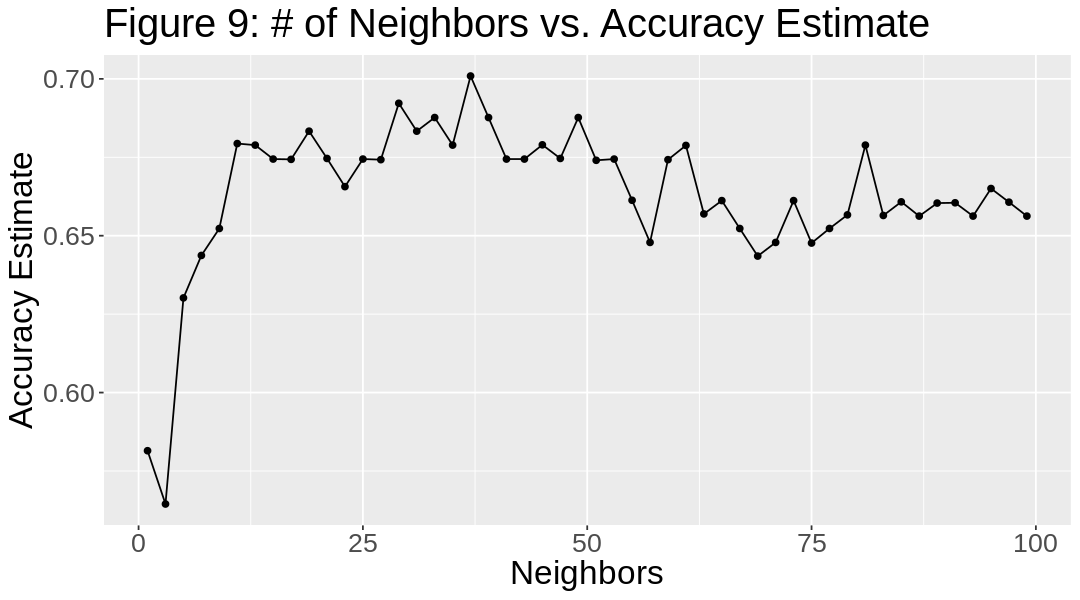

In [92]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle('Figure 9: # of Neighbors vs. Accuracy Estimate') +
    theme(text = element_text(size = 20))

k_best <- knn_results |>
   filter(.metric == "accuracy") |>
   arrange(.metric) |> 
   filter(mean == max(mean)) |>
   pull(neighbors)

cross_val_plot
accuracies
k_best

We can see above that k = 37 yields the best accuracy, with an accuracy of around 70%, while nearby values of k drop to around 67%. k = 37 also exists within a sort of "plateau" in accuracy, near the center of other elevated accuracy values.

### Re-training the model

Now that we have identified our best value of k, we can use it to re-train our K-Nearest Neighbours Classification model. 

In [93]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) |>
              set_engine("kknn") |>
              set_mode("classification")

heart_disease_fit <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(knn_best_spec) |>
        fit(data=heart_training)

heart_disease_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(37,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3039648
Best kernel: rectangular
Best k: 37

### Predicting on Testing Data and Calculating Accuracy Estimate

Now that we have our model, we will use this to predict the values in our testing set. We will also find an accuracy estimate for our predictor.

In [94]:
heart_predictions <- predict(heart_disease_fit, heart_testing) |>
                     bind_cols(heart_testing)

heart_metrics <- heart_predictions |>
                metrics(truth=diagnosis,estimate=.pred_class)

heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6447368
kap,binary,0.2835196


As shown above, our k-nearest neighbors classification model has an accuracy estimate of about 64%.

### Confusion Matrix of Results

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



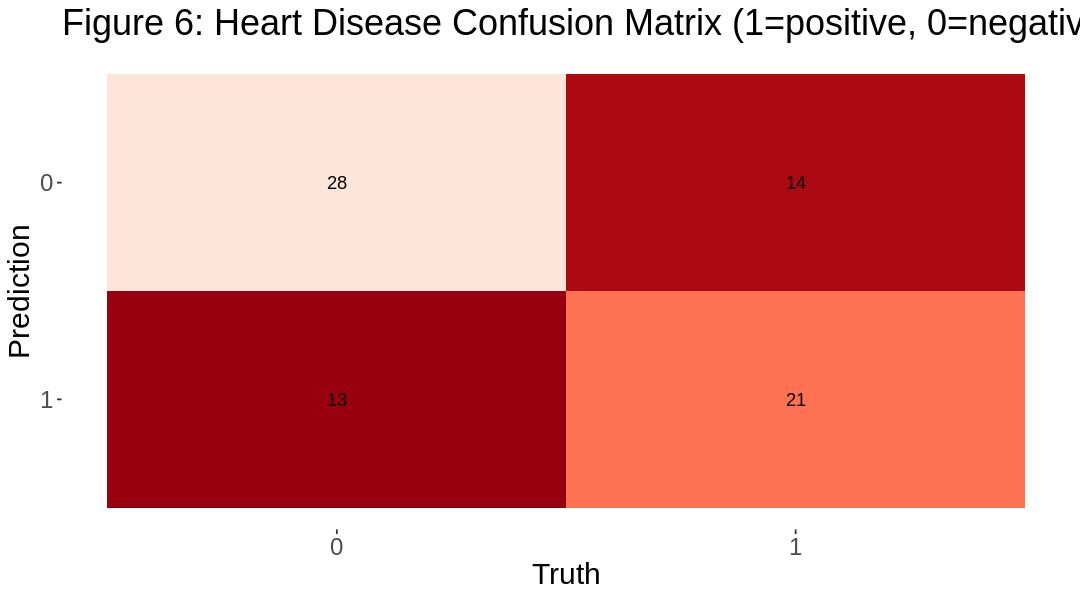

In [95]:
heart_cm <- conf_mat(heart_predictions, truth = diagnosis, estimate = .pred_class)

autoplot(heart_cm, type = "heatmap") +
    scale_fill_distiller(palette = "Reds") + 
    labs(title = "Figure 6: Heart Disease Confusion Matrix (1=positive, 0=negative)") +
    theme(text=element_text(size=18))
    

As we can see above, our classifier correctly identified 28 negative samples and 21 positive samples, but misidentified 13 negatives as positive and 14 positive results as negatives. 

## Discussion

We found that there was a positive relationship between age and heart disease. We expected to find this, as a person's immune system tends to weaken as they age and thus more susceptible to illnesses. From our max heart rate variable, we can see that people with a lower heart rate tend to have a positive diagnosis. The cutoff is around 150; heart rates below 150 are mostly positive and heart rates above 150 are mostly negative. For cholesterol level, we cannot see an obvious pattern, concluding that cholesterol level does not play an important role in predicting the diagnosis of heart disease.

The low accuracy of our classifier is due to the complexity of heart disease and numerous different factors that contribute to it. Due to how difficult it is to predict heart disease, mispredictions are inevitable, even for doctors. With a higher dimensionality, having more samples or using more complex data analysis techniques, it is possible that a higher accuracy can be achieved. 

Being able to predict if someone has heart disease accurately is important because it can allow us to diagnose heart disease early, potentially assess the progression of the disease and prevent life threats or other serious symptoms. In general, most if not all diseases are easier to treat when they are detected earlier than later. (Duprez 2006- ESC Council of Cardiology). Clinicians will be able to give treatment without any serious effects. Our findings can also tell us what factors are correlated with heart disease and, upon further research, how we can adjust our lifestyle to prevent severe illness.

Our analysis leads to several followup questions, such as:

* What are the optimal ranges for blood pressure and cholesterol levels (at each age range) to prevent heart disease?
* Are there any confounding variables that could be affecting our findings?
* How can our findings be extended to individuals in other parts of the world? Would geographic location impact the accuracy of our model?

## References


At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

Dataset Source:

https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Literature:

Thomas, Jen. Heart Disease: Facts, Statistics and You. Healthline.

https://www.healthline.com/health/heart-disease/statistics#Who-is-at-risk


Duprez, Daniel. Early Detection of Cardiovascular Disease - the Future of Cardiology. E Journal of the ESC Council of Cardiology.

https://www.escardio.org/Journals/E-Journal-of-Cardiology-Practice/Volume-4/vol4n19-Title-Early-detection-of-cardiovascular-disease-the-future-of-cardi